In [1]:
# Connect to Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:
# do all of the imports
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
import joblib

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import string
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Utility Function for history plotting
# adapted from a RealPython tutorial: 
#    https://realpython.com/python-keras-text-classification/
def plot_history(history, file_name):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig(file_name, bbox_inches='tight')

In [4]:
# Utility Function for data cleaning pipeline
def text_pipeline(row):
    genre = row["genre"]
    descr = row["description"]
    text = genre + " " + descr
    # split into words
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # join the words and return them to be loaded into the dataframe
    return " ".join(words)

In [5]:
!ls gdrive/MyDrive/Colab\ Notebooks/Final-Project/Resource/
!pwd

IMDb_movies.csv  IMDB_sean.csv
/content


In [6]:
# Load in the IMDB_sean file
df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Final-Project/Resource/IMDB_sean.csv")
df.head()

,Unnamed: 0,title,year,genre,description,budget,usa_gross_income,worlwide_gross_income,profit_factor
0,165,Il gabinetto del dottor Caligari,1920,"Fantasy, Horror, Mystery","Hypnotist Dr. Caligari uses a somnambulist, Ce...",18000.0,8811.0,8811.0,loss
1,245,I quattro cavalieri dell'Apocalisse,1921,"Drama, Romance, War",An extended family split up in France and Germ...,800000.0,9183673.0,9183673.0,large gain
2,506,Metropolis,1927,"Drama, Sci-Fi",In a futuristic city sharply divided between t...,6000000.0,1236166.0,1349711.0,loss
3,1048,Luci della città,1931,"Comedy, Drama, Romance","With the aid of a wealthy erratic tippler, a d...",1500000.0,19181.0,46008.0,loss
4,2454,Tempi moderni,1936,"Comedy, Drama, Family",The Tramp struggles to live in modern industri...,1500000.0,163577.0,457688.0,loss


In [7]:
 # Run the Genre and Description thru the text pipeline for joining and cleaning
 df["words"] = df.apply(text_pipeline, axis=1)
 df.head()
 print(df["words"].map(lambda x: len(x)).max())

315


In [8]:
# Define the X and y parameters
sentences = df["words"].values
y = df["profit_factor"].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=42)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

# scale the data with StandardScaler
X_scaler = StandardScaler(with_mean=False).fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Label Encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
joblib.dump(label_encoder, "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/sean_logistic_regression_le.sav")
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [32]:
# Run Logistic Regression
classifier = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
classifier.fit(X_train_scaled, encoded_y_train)
score = classifier.score(X_test_scaled, encoded_y_test)

print("Accuracy:", score)
print(f"Training Data Score: {classifier.score(X_train_scaled, encoded_y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, encoded_y_test)}")

Accuracy: 0.28205128205128205
Training Data Score: 0.9986844269034698
Testing Data Score: 0.28205128205128205


In [10]:
# Hyperparameter Tuning
param_grid = {'C': [10, 50, 100],
              'max_iter': [200, 500, 1000]}
grid = GridSearchCV(classifier, param_grid, verbose=3)
# Train the model with GridSearch
grid.fit(X_train_scaled, encoded_y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=10, max_iter=200 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] .................. C=10, max_iter=200, score=0.292, total=   4.7s
[CV] C=10, max_iter=200 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV] .................. C=10, max_iter=200, score=0.278, total=   4.6s
[CV] C=10, max_iter=200 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=10, max_iter=200, score=0.295, total=   4.3s
[CV] C=10, max_iter=200 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=10, max_iter=200, score=0.249, total=   4.8s
[CV] C=10, max_iter=200 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=10, max_iter=200, score=0.262, total=   4.9s
[CV] C=10, max_iter=500 ..............................................
[CV] .................. C=10, max_iter=500, score=0.295, total=  10.3s
[CV] C=10, max_iter=500 ..............................................
[CV] .................. C=10, max_iter=500, score=0.276, total=   9.7s
[CV] C=10, max_iter=500 ..............................................
[CV] .................. C=10, max_iter=500, score=0.295, total=   6.7s
[CV] C=10, max_iter=500 ..............................................
[CV] .................. C=10, max_iter=500, score=0.248, total=  10.0s
[CV] C=10, max_iter=500 ..............................................
[CV] .................. C=10, max_iter=500, score=0.262, total=   4.5s
[CV] C=10, max_iter=1000 .............................................
[CV] ................. C=10, max_iter=1000, score=0.295, total=  10.2s
[CV] C=10, max_iter=1000 .............................................
[CV] .

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=50, max_iter=200, score=0.281, total=   4.7s
[CV] C=50, max_iter=200 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=50, max_iter=200, score=0.269, total=   4.6s
[CV] C=50, max_iter=200 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=50, max_iter=200, score=0.295, total=   4.6s
[CV] C=50, max_iter=200 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=50, max_iter=200, score=0.251, total=   4.5s
[CV] C=50, max_iter=200 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=50, max_iter=200, score=0.259, total=   4.7s
[CV] C=50, max_iter=500 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=50, max_iter=500, score=0.280, total=  10.9s
[CV] C=50, max_iter=500 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=50, max_iter=500, score=0.266, total=  11.4s
[CV] C=50, max_iter=500 ..............................................
[CV] .................. C=50, max_iter=500, score=0.293, total=   9.0s
[CV] C=50, max_iter=500 ..............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .................. C=50, max_iter=500, score=0.252, total=  11.5s
[CV] C=50, max_iter=500 ..............................................
[CV] .................. C=50, max_iter=500, score=0.260, total=   7.2s
[CV] C=50, max_iter=1000 .............................................
[CV] ................. C=50, max_iter=1000, score=0.283, total=  14.6s
[CV] C=50, max_iter=1000 .............................................
[CV] ................. C=50, max_iter=1000, score=0.266, total=  15.3s
[CV] C=50, max_iter=1000 .............................................
[CV] ................. C=50, max_iter=1000, score=0.293, total=   9.4s
[CV] C=50, max_iter=1000 .............................................
[CV] ................. C=50, max_iter=1000, score=0.252, total=  13.5s
[CV] C=50, max_iter=1000 .............................................
[CV] ................. C=50, max_iter=1000, score=0.260, total=   6.8s
[CV] C=100, max_iter=200 .............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................. C=100, max_iter=200, score=0.279, total=   4.6s
[CV] C=100, max_iter=200 .............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................. C=100, max_iter=200, score=0.272, total=   4.6s
[CV] C=100, max_iter=200 .............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................. C=100, max_iter=200, score=0.294, total=   4.4s
[CV] C=100, max_iter=200 .............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................. C=100, max_iter=200, score=0.252, total=   5.0s
[CV] C=100, max_iter=200 .............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................. C=100, max_iter=200, score=0.255, total=   4.6s
[CV] C=100, max_iter=500 .............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................. C=100, max_iter=500, score=0.282, total=  11.2s
[CV] C=100, max_iter=500 .............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................. C=100, max_iter=500, score=0.271, total=  11.4s
[CV] C=100, max_iter=500 .............................................
[CV] ................. C=100, max_iter=500, score=0.295, total=  10.7s
[CV] C=100, max_iter=500 .............................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ................. C=100, max_iter=500, score=0.252, total=  11.2s
[CV] C=100, max_iter=500 .............................................
[CV] ................. C=100, max_iter=500, score=0.255, total=   9.7s
[CV] C=100, max_iter=1000 ............................................
[CV] ................ C=100, max_iter=1000, score=0.281, total=  19.8s
[CV] C=100, max_iter=1000 ............................................
[CV] ................ C=100, max_iter=1000, score=0.271, total=  17.6s
[CV] C=100, max_iter=1000 ............................................
[CV] ................ C=100, max_iter=1000, score=0.295, total=  11.3s
[CV] C=100, max_iter=1000 ............................................
[CV] ................ C=100, max_iter=1000, score=0.253, total=  14.7s
[CV] C=100, max_iter=1000 ............................................
[CV] ................ C=100, max_iter=1000, score=0.255, total=  10.0s


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  6.5min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [10, 50, 100], 'max_iter': [200, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [11]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 10, 'max_iter': 200}
0.2751164965618648


In [12]:
# Confusion Matrix
y_pred = classifier.predict(X_test_scaled)
confusion_matrix(encoded_y_test, y_pred)

array([[ 97,  79, 147, 134],
       [ 92,  66, 133, 101],
       [114,  90, 180, 149],
       [154, 102, 161, 229]])

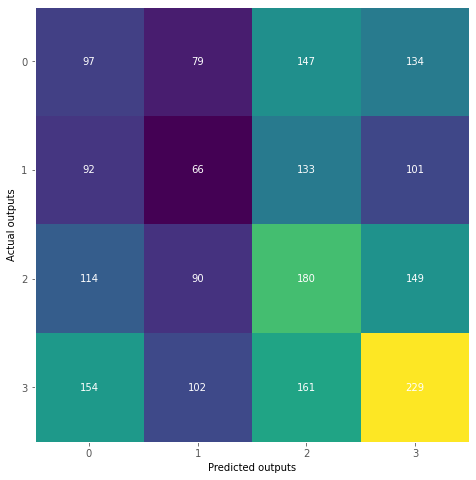

<Figure size 432x288 with 0 Axes>

In [16]:
cm = confusion_matrix(encoded_y_test, y_pred)
font_size = 10
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=font_size, color='black')
ax.set_ylabel('Actual outputs', fontsize=font_size, color='black')
ax.xaxis.set(ticks=range(4))
ax.yaxis.set(ticks=range(4))
ax.set_ylim(3.5, -0.5)
for i in range(4):
    for j in range(4):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()
plt.savefig("gdrive/MyDrive/Colab Notebooks/Final-Project/Images/LR_ConfusionMatrix.png", bbox_inches='tight')

In [13]:
# Save the Model
file_name = "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/sean_Logistic_Regression.sav"
joblib.dump(classifier, file_name)

['gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/sean_Logistic_Regression.sav']

In [33]:
# get a list of models to evaluate
def get_models():
	models = dict()
	for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
		# create name for model
		key = '%.4f' % p
		# turn off penalty in some cases
		if p == 0.0:
			# no penalty in this case
			models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
		else:
			models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

>0.0000 0.277 (0.022)
>0.0001 0.323 (0.024)
>0.0010 0.315 (0.030)
>0.0100 0.301 (0.029)
>0.1000 0.288 (0.026)
>1.0000 0.284 (0.027)


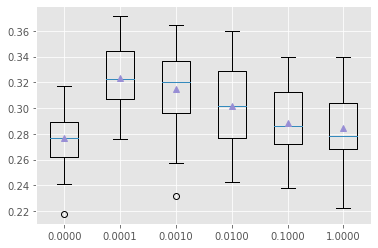

In [37]:

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = evaluate_model(model, X_test_scaled, encoded_y_test)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize progress along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.savefig("gdrive/MyDrive/Colab Notebooks/Final-Project/Images/LR_PenaltyConfig.png", bbox_inches='tight')
plt.show()